### Working with Large Datasets

Sometimes in climate, we have very large datasets that don't all fit in memory or even if they do will take a long time to calculate. We can use `dask` to handle the data in `chunks` that will fit in memory and/or be computed in parallel. 

### Dask Arrays

[Dask](https://dask.org/)

[Dask and Xarray](http://xarray.pydata.org/en/stable/dask.html)

A `dask` array looks and feels a lot like a `numpy` array. However, a `dask` array doesn’t directly hold any data. Instead, it symbolically represents the computations needed to generate the data. Nothing is actually computed until the actual numerical values are needed. This mode of operation is called “lazy”; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

From 
https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
shape=(1000,4000)
ones_np=np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [4]:
ones_np.nbytes/1e6

32.0

In [5]:
import dask.array as da
ones=da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [6]:
chunk_shape=(1000,1000)
ones=da.ones(shape,chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [7]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

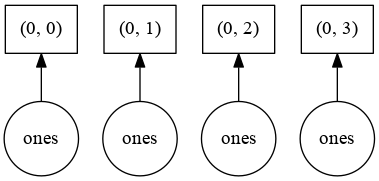

In [8]:
ones.visualize()

### Install graphviz
`conda install graphviz python-graphviz`

In [9]:
#conda install graphviz python-graphviz

In [10]:
sum_of_ones=ones.sum()

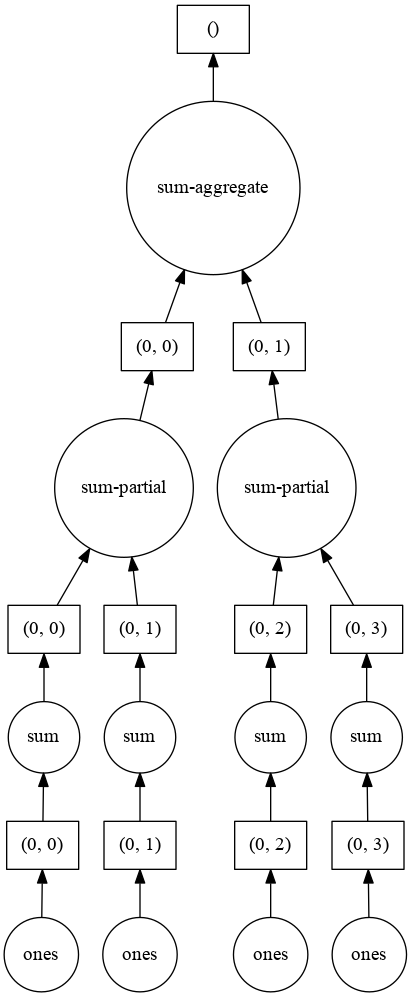

In [11]:
sum_of_ones.visualize()

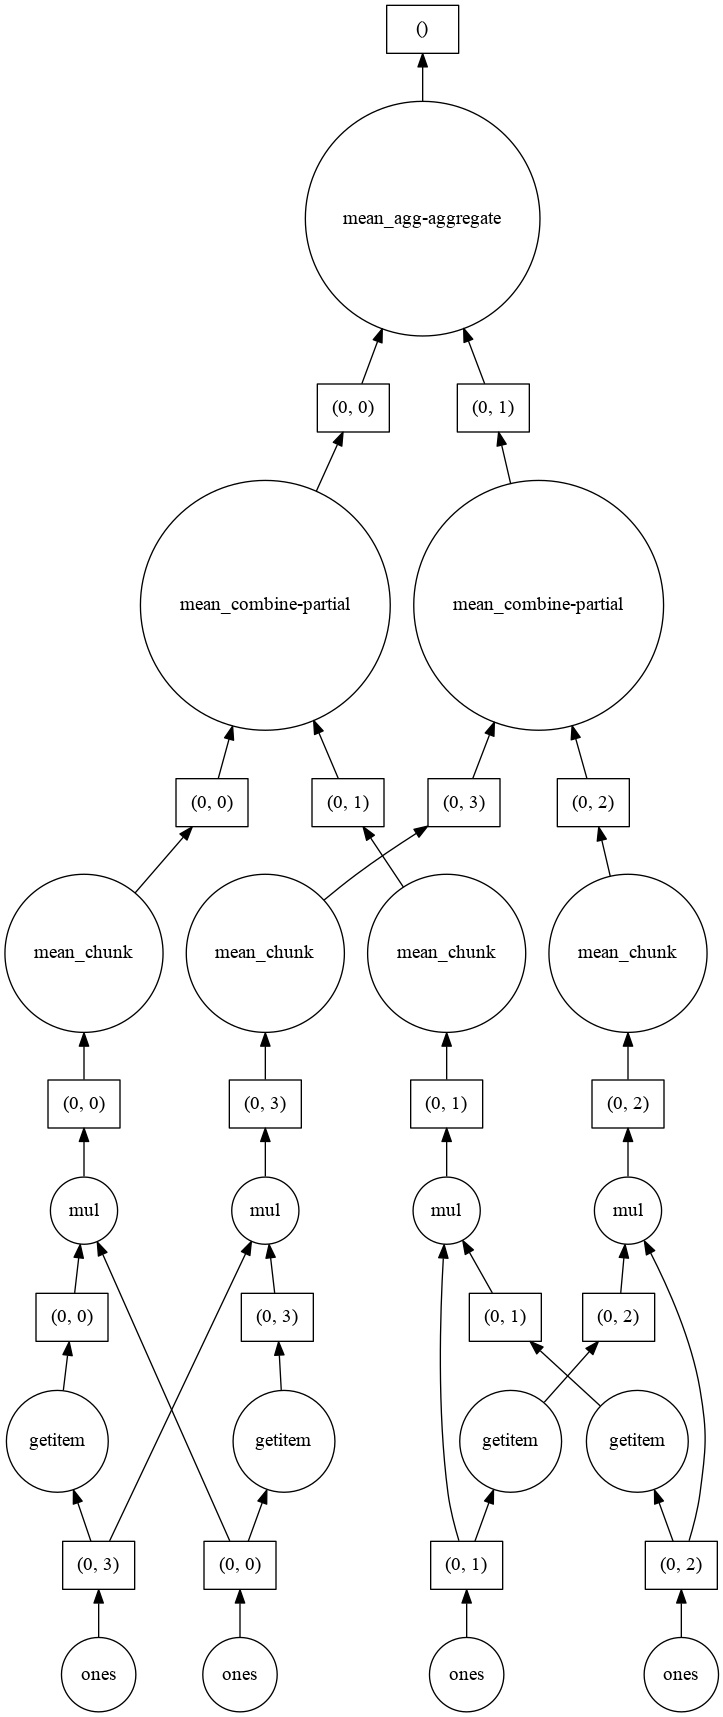

In [12]:
fancy_calculation=(ones*ones[::-1,::-1]).mean()
fancy_calculation.visualize()

### A Big Calculation

The examples above were toy examples (32Mb).  This data is not big enough to warrant the use of `dask`.  Let's try a much bigger example

In [13]:
bigshape=(200000,4000)
big_ones=da.ones(bigshape,chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [14]:
big_ones.nbytes/1e6

6400.0

DO NOT VISUALIZE THIS!

### Dask has some tools to help us undertand what is happening 

In [15]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  1.7s


1.0

#### All the usual `numpy` (and `xarray`) methods work on `dask` arrays.

In [16]:
big_ones_reduce=(np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

### Xarray uses dask by default when you use open_mfdataset 
`dask` can be invoked by specifying `chunks` when you open and read your data.

Example: ERA-Interim Daily Data
File for every day from 1980-2015 


In [17]:
path='/shared/working/rean/era-interim/daily/data/'
fname='ei.oper.an.pl.regn128cm.'

In [18]:
# Create a list of many files to open and read
fnames = path+'1999/'+fname+'199901*'
fnames

'/shared/working/rean/era-interim/daily/data/1999/ei.oper.an.pl.regn128cm.199901*'

In [19]:
#!ls /shared/working/rean/era-interim/daily/data/1999/ei.oper.an.pl.regn128cm.199901*

In [20]:
#ds=xr.open_mfdataset(fnames,combine='nested',concat_dim='time',engine='cfgrib',
#                     backend_kwargs={'indexpath':''},parallel=True)

In [21]:
ds=xr.open_mfdataset(fnames,combine='nested',concat_dim='time',engine='cfgrib',
                     backend_kwargs={'indexpath':''},parallel=False)

In [22]:
ds.nbytes/1e9

8.419023656

In [23]:
#ds

### Here are a few situations when you need to pay attention to the fact that you are using `dask` arrays

__When you get a `chunking` error__

Remember when we did `rolling` and got an error

`daily_climo_smooth=ds_daily_climo.rolling(dayofyear=30,center=True).mean()`

`For window size 30, every chunk should be larger than 15, but the smallest chunk size is 1. Rechunk your array with a larger chunk size or a chunk size that more evenly divides the shape of your array.`

`Dask` was telling us that it couldn't work with the data in its current `chunks`, so we `rechunked` it using:
`ds_daily_climo=ds_daily_climo.chunk({'dayofyear':-1})`

__When you want to use computations over and over__

Example: I calculate anomalies for a really large dataset and I then want to use the anomalies for the rest of the program without asking `dask` to recompute them over and over.

__When you have a performance issue__

If it is taking a long time to do the calculations, you can tell `dask` to go ahead and `load` the data if you have enough memory or go ahead and `compute` the computations up to this point.  

See how long it is taking with the progress bar.

[########################################] | 100% Completed | 11.7s


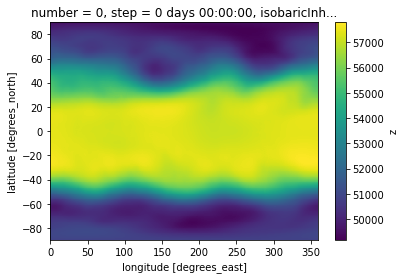

In [24]:
with ProgressBar():
    ds['z'].sel(isobaricInhPa=500).groupby('time.year').mean().plot()

In [25]:
ds_load=ds['z'].sel(isobaricInhPa=500).load()

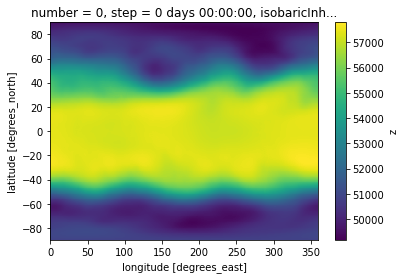

In [26]:
with ProgressBar():
    ds_load.groupby('time.year').mean().plot()

__When you have a memory issue__

If it is running out of memory, you can tell it to work on your data in parallel by distributing the chunks across cores.

In [27]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2,thread_per_worker=8)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34998 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [28]:
#with ProgressBar():
#    ds['z'].sel(isobaricInhPa=500).groupby('time.year').mean().plot()